# 평가원

# 교육청

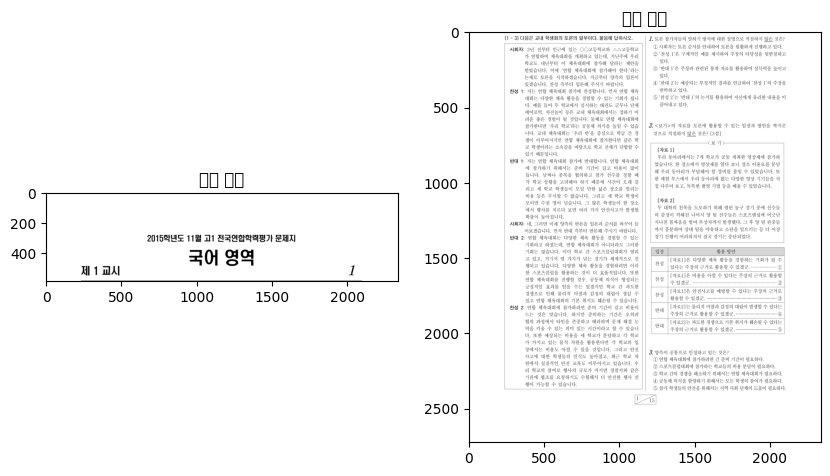

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 이미지 불러오기
image_path = r'/content/drive/MyDrive/빅데이터 7기/final/2015_G1_11_KOR/KOR_page0.png'  # 올바른 경로로 설정
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지가 제대로 로드되지 않았는지 확인
if image is None:
    print(f"이미지를 불러오지 못했습니다: {image_path}")
else:
    # 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # 윤곽선 찾기
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 가로선 찾기
    horizontal_lines = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 700 and h < 50:  # 너비가 특정 값 이상이고 높이가 작은 가로선 찾기
            horizontal_lines.append((x, y, w, h))

    # 제일 작은 y값을 가진 가로선 찾기
    if horizontal_lines:
        horizontal_lines.sort(key=lambda line: line[1])  # y 값을 기준으로 정렬
        smallest_y_line = horizontal_lines[0]  # y 값이 제일 작은 가로선
        x, y, w, h = smallest_y_line
        cut_line = y + h // 2  # 가로선의 중심 위치 계산

        upper_part = image[:cut_line, :]  # 가로선 중심까지 포함
        lower_part = image[cut_line:, :]  # 가로선 중심 아래부터 시작

        # # 이미지 저장
        # upper_part_path = '/mnt/data/upper_part.png'
        # lower_part_path = '/mnt/data/lower_part.png'
        # cv2.imwrite(upper_part_path, upper_part)
        # cv2.imwrite(lower_part_path, lower_part)

        # 이미지 출력
        plt.figure(figsize=(10, 8))

        plt.subplot(1, 2, 1)
        plt.title('상단 부분')
        plt.imshow(cv2.cvtColor(upper_part, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 2, 2)
        plt.title('하단 부분')
        plt.imshow(cv2.cvtColor(lower_part, cv2.COLOR_BGR2RGB))

        plt.show()

    else:
        print("500픽셀 근처에 가로로 긴 선을 찾을 수 없습니다.")


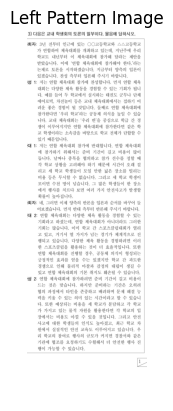

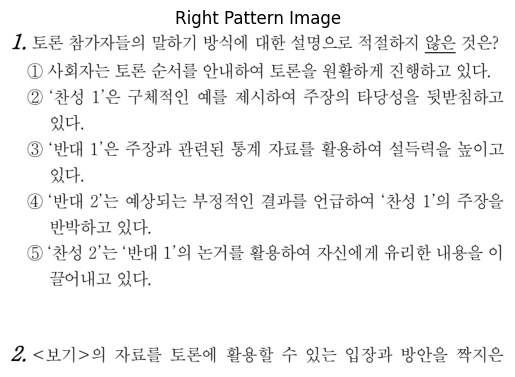

In [36]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'], gpu=True)  # 사용할 언어 설정

def find_pattern_area(image, pattern):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_area(results):
        pattern_start = None
        pattern_end = None
        found_first_pattern = False

        for detection in results:
            text = detection[1]
            if re.search(pattern, text):
                bbox = detection[0]

                if not found_first_pattern:
                    pattern_start = bbox
                    found_first_pattern = True
                else:
                    pattern_end = bbox
                    break

        # 패턴의 시작과 끝 사이의 영역을 반환
        if pattern_start and pattern_end:
            # bbox 좌표에서 네 개의 값 중 가장 작은 x, y 좌표와 가장 큰 x, y 좌표를 추출
            x1 = min(pattern_start[0][0], pattern_end[0][0])
            y1 = min(pattern_start[0][1], pattern_end[0][1])
            x2 = max(pattern_start[2][0], pattern_end[2][0])
            y2 = max(pattern_start[2][1], pattern_end[2][1])
            return (x1, y1, x2, y2)
        elif pattern_start and not pattern_end:
            return (pattern_start[0][0], pattern_start[0][1], width//2, height)
        else:
            return None

    # 좌측 이미지에서 패턴 영역 찾기
    left_pattern_area = get_pattern_area(left_results)
    if left_pattern_area:
        left_pattern_image = left_image[int(left_pattern_area[1]):int(left_pattern_area[3]),
                                       int(left_pattern_area[0]):int(left_pattern_area[2])]
    else:
        left_pattern_image = None

    # 우측 이미지에서 패턴 영역 찾기
    right_pattern_area = get_pattern_area(right_results)
    if right_pattern_area:
        right_pattern_image = right_image[int(right_pattern_area[1]):int(right_pattern_area[3]),
                                         int(right_pattern_area[0]):int(right_pattern_area[2])]
    else:
        right_pattern_image = None

    return left_pattern_image, right_pattern_image

# 이미지 경로와 패턴 정의
image_path = '/content/drive/MyDrive/빅데이터 7기/final/2015_G1_11_KOR/KOR_page0.png'
pattern = r'\[\d+[^\]]*\]|\d+\]|\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 패턴 영역을 찾아 좌우 이미지 자르기
left_pattern_image, right_pattern_image = find_pattern_area(image, pattern)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if left_pattern_image is not None:
    left_pattern_image_rgb = cv2.cvtColor(left_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(left_pattern_image_rgb)
    plt.axis('off')
    plt.title('Left Pattern Image')
    plt.show()
else:
    print("좌측 이미지에서 해당 패턴을 찾을 수 없습니다.")

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if right_pattern_image is not None:
    right_pattern_image_rgb = cv2.cvtColor(right_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(right_pattern_image_rgb)
    plt.axis('off')
    plt.title('Right Pattern Image')
    plt.show()
else:
    print("우측 이미지에서 해당 패턴을 찾을 수 없습니다.")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


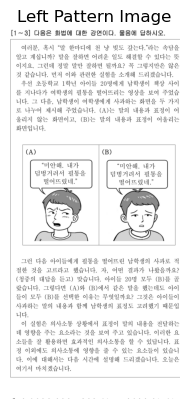

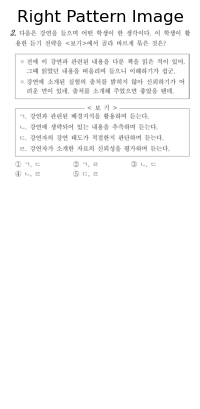

In [10]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'])  # 사용할 언어 설정

def find_pattern_area(image, pattern, padding=40):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_area(results):
        pattern_start = None
        pattern_end = None
        found_first_pattern = False

        for detection in results:
            text = detection[1]
            if re.search(pattern, text):
                bbox = detection[0]

                if not found_first_pattern:
                    pattern_start = bbox
                    found_first_pattern = True
                else:
                    pattern_end = bbox
                    break

        # 패턴의 시작과 끝 사이의 영역을 반환
        if pattern_start and pattern_end:
            # bbox 좌표에서 네 개의 값 중 가장 작은 x, y 좌표와 가장 큰 x, y 좌표를 추출
            x1 = min(pattern_start[0][0], pattern_end[0][0])
            y1 = min(pattern_start[0][1], pattern_end[0][1])
            x2 = max(pattern_start[2][0], pattern_end[2][0])
            y2 = max(pattern_start[2][1], pattern_end[2][1]) - padding
            return (x1, y1, x2, y2)
        elif pattern_start and not pattern_end:
            return (pattern_start[0][0], pattern_start[0][1], width//2, height - padding)
        else:
            return None

    # 좌측 이미지에서 패턴 영역 찾기
    left_pattern_area = get_pattern_area(left_results)
    if left_pattern_area:
        left_pattern_image = left_image[int(left_pattern_area[1]):int(left_pattern_area[3]),
                                       int(left_pattern_area[0]):int(left_pattern_area[2])]
    else:
        left_pattern_image = None

    # 우측 이미지에서 패턴 영역 찾기
    right_pattern_area = get_pattern_area(right_results)
    if right_pattern_area:
        right_pattern_image = right_image[int(right_pattern_area[1]):int(right_pattern_area[3]),
                                         int(right_pattern_area[0]):int(right_pattern_area[2])]
    else:
        right_pattern_image = None

    return left_pattern_image, right_pattern_image

# 이미지 경로와 패턴 정의
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\test\2015_G1_3_KOR\kor_page0.png'
pattern = r'\[(\d+)|\d+\]|\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지 로드 확인
if image is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# 패턴 영역을 찾아 좌우 이미지 자르기
left_pattern_image, right_pattern_image = find_pattern_area(image, pattern, padding=40)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if left_pattern_image is not None:
    left_pattern_image_rgb = cv2.cvtColor(left_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(left_pattern_image_rgb)
    plt.axis('off')
    plt.title('Left Pattern Image')
    plt.show()
else:
    print("좌측 이미지에서 해당 패턴을 찾을 수 없습니다.")

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if right_pattern_image is not None:
    right_pattern_image_rgb = cv2.cvtColor(right_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(right_pattern_image_rgb)
    plt.axis('off')
    plt.title('Right Pattern Image')
    plt.show()
else:
    print("우측 이미지에서 해당 패턴을 찾을 수 없습니다.")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


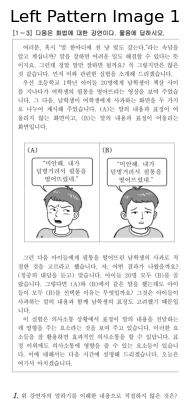

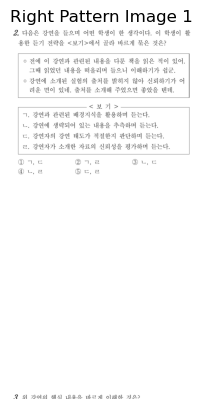

In [16]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'], gpu=True)  # 사용할 언어 설정

def find_pattern_areas(image, pattern1, pattern2, padding=10):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_areas(results, image_half_width):
        pattern_areas = []
        found_first_pattern = False
        pattern_start = None

        for detection in results:
            text = detection[1]
            if re.search(pattern1, text) or re.search(pattern2, text):
                bbox = detection[0]
                if not found_first_pattern:
                    pattern_start = bbox
                    found_first_pattern = True
                else:
                    pattern_end = bbox
                    x1 = min(pattern_start[0][0], pattern_end[0][0])
                    y1 = min(pattern_start[0][1], pattern_end[0][1])
                    x2 = max(pattern_start[2][0], pattern_end[2][0])
                    y2 = max(pattern_start[2][1], pattern_end[2][1]) - padding
                    pattern_areas.append((x1, y1, x2, y2))
                    pattern_start = pattern_end
                    found_first_pattern = False

        if found_first_pattern:
            x1 = pattern_start[0][0]
            y1 = pattern_start[0][1]
            x2 = image_half_width
            y2 = height - padding
            pattern_areas.append((x1, y1, x2, y2))

        return pattern_areas

    # 좌측 이미지에서 패턴 영역들 찾기
    left_pattern_areas = get_pattern_areas(left_results, width//2)
    left_pattern_images = [left_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in left_pattern_areas]

    # 우측 이미지에서 패턴 영역들 찾기
    right_pattern_areas = get_pattern_areas(right_results, width//2)
    right_pattern_images = [right_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in right_pattern_areas]

    return left_pattern_images, right_pattern_images

# 이미지 경로와 패턴 정의
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\test\2015_G1_3_KOR\kor_page0.png'
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지 로드 확인
if image is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# 패턴 영역들을 찾아 좌우 이미지 자르기
left_pattern_images, right_pattern_images = find_pattern_areas(image, pattern1, pattern2, padding=10)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(left_pattern_images):
    if pattern_image is not None:
        left_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(left_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Left Pattern Image {idx+1}')
        plt.show()

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(right_pattern_images):
    if pattern_image is not None:
        right_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(right_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Right Pattern Image {idx+1}')
        plt.show()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


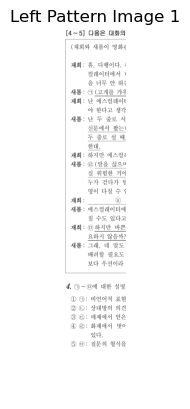

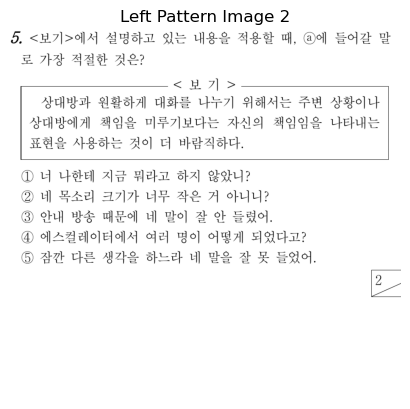

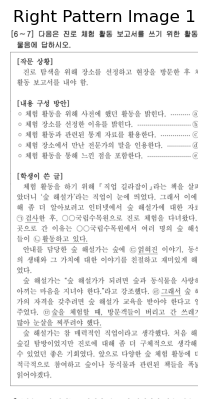

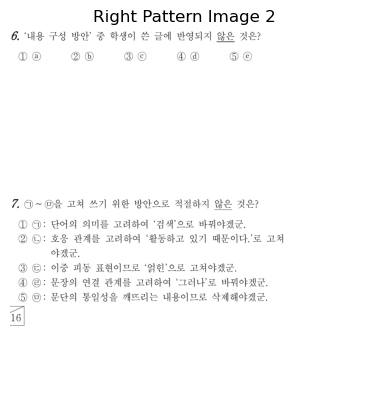

In [29]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'], gpu=True)  # 사용할 언어 설정

def find_pattern_areas(image, pattern1, pattern2, padding=50):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_areas(results, image_half_width):
        pattern_areas = []
        pattern_start = None

        for detection in results:
            text = detection[1]
            if re.search(pattern1, text) or re.search(pattern2, text):
                bbox = detection[0]
                if pattern_start is None:
                    pattern_start = bbox
                else:
                    pattern_end = bbox
                    x1 = min(pattern_start[0][0], pattern_end[0][0])
                    y1 = min(pattern_start[0][1], pattern_end[0][1])
                    x2 = max(pattern_start[2][0], pattern_end[2][0])
                    y2 = max(pattern_start[2][1], pattern_end[2][1]) - padding
                    pattern_areas.append((x1, y1, x2, y2))
                    pattern_start = pattern_end

        if pattern_start:
            x1 = pattern_start[0][0]
            y1 = pattern_start[0][1]
            x2 = image_half_width
            y2 = height
            pattern_areas.append((x1, y1, x2, y2))

        return pattern_areas

    # 좌측 이미지에서 패턴 영역들 찾기
    left_pattern_areas = get_pattern_areas(left_results, width//2)
    left_pattern_images = [left_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in left_pattern_areas]

    # 우측 이미지에서 패턴 영역들 찾기
    right_pattern_areas = get_pattern_areas(right_results, width//2)
    right_pattern_images = [right_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in right_pattern_areas]

    return left_pattern_images, right_pattern_images

# 이미지 경로와 패턴 정의
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\test\2015_G1_3_KOR\kor_page1.png'
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지 로드 확인
if image is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# 패턴 영역들을 찾아 좌우 이미지 자르기
left_pattern_images, right_pattern_images = find_pattern_areas(image, pattern1, pattern2, padding=40)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(left_pattern_images):
    if pattern_image is not None:
        left_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(left_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Left Pattern Image {idx+1}')
        plt.show()

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(right_pattern_images):
    if pattern_image is not None:
        right_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(right_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Right Pattern Image {idx+1}')
        plt.show()


# 깃허브 참고

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[242, 16], [1044, 16], [1044, 60], [242, 60]],
  '[1 ~3] 다음은 화번에 대한 강연이다. 물음에 답하시오.',
  0.39115543536460595),
 ([[293, 93], [474, 93], [474, 137], [293, 137]],
  '여러분   혹시',
  0.7587176470673871),
 ([[489, 93], [664, 93], [664, 137], [489, 137]],
  '"말   한마디에',
  0.7458703627962887),
 ([[674, 91], [1122, 91], [1122, 140], [674, 140]],
  '천 낭 빗도 갚는다 "라는  속담올',
  0.20756027626384377),
 ([[271, 136], [1122, 136], [1122, 187], [271, 187]],
  '알고 계십니까? 말울 잘하면 어려운 일도 해결활 수 있다는 뜻',
  0.306879917640405),
 ([[270, 191], [367, 191], [367, 231], [270, 231]], '이지요', 0.9998514071913761),
 ([[378, 186], [1121, 186], [1121, 231], [378, 231]],
  '그런데   정말   말만   잘하면   돌까요?   꼭 그렇지만은 않은',
  0.32881906446123543),
 ([[270, 233], [1088, 233], [1088, 278], [270, 278]],
  '것  같습니다.  먼저 이와  관련한  실험올 소개해 드리켓습니다.',
  0.3021395067210669),
 ([[292, 276], [1119, 276], [1119, 325], [292, 325]],
  '우선   초등학교  1학년   아이들   20명에게  남학생이   책상   사이',
  0.5233556766953527),
 ([[270, 325], [1121, 325], [1121, 369], [270

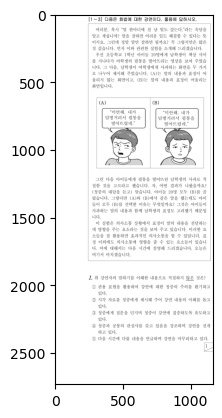

In [61]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left__page0.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

In [4]:
# PNG img to OCR txt
## GPU 있을시 자동으로 GPU 동작

import easyocr

reader = easyocr.Reader(['ko','en'])
ocr_txt = reader.readtext(r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\MAHT_page0.png')

# bounding box, text, confident level.
for b_box, text, cf_level in ocr_txt:
    print(b_box, text, cf_level)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[[614, 293], [1730, 293], [1730, 373], [614, 373]] 2015학년도 3월 고1 전국연합학력평가 문제지 0.8909455709628676
[[288, 428], [510, 428], [510, 507], [288, 507]] 제 1 교시 0.5766735429943115
[[936, 401], [1402, 401], [1402, 547], [936, 547]] 국어 영역 0.756625680223812
[[2049, 488], [2094, 488], [2094, 551], [2049, 551]] 1 0.9997255990420086
[[242, 596], [351, 596], [351, 636], [242, 636]] [1 ~3] 0.5234373905774199
[[364, 596], [1042, 596], [1042, 638], [364, 638]] 다음은 화번에 대한 강연이다. 물음에 답하시오 0.6827442569597052
[[1193, 601], [2096, 601], [2096, 644], [1193, 644]] 2. 다음은  강연올 들으며 어떤   학생이   한  생각이다. 이 학생이   활 0.20936011558809334
[[1219, 653], [1978, 653], [1978, 695], [1219, 695]] 용한   듣기   전락올  <보기> 에서   콜라 바르게   묶은 것은? 0.3750866487208791
[[296, 671], [1119, 671], [1119, 716], [296, 716]] 여러분   혹시   "말   한마디에   천 낭 빗도 갚늘다 "라는   속담올 0.1823826608725571
[[271, 720], [1122, 720], [1122, 763], [271, 763]] 알고   계십니까?   말을 잘하면 어려운 일도 해결할  수 있다는 뜻 0.23302840131164784
[[1274, 744], [2068, 744], [2068, 786], [1274, 786]

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


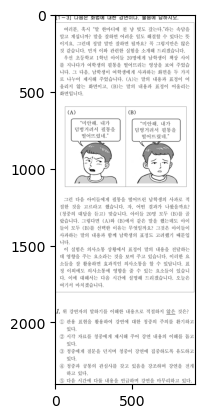

In [66]:
import cv2
import easyocr
import re
from PIL import Image
from matplotlib.pyplot import imshow

# 이미지 파일 경로
f_name = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left__page0.png'

# 이미지 열기
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

# EasyOCR을 사용하여 숫자와 점을 인식
reader = easyocr.Reader(['ko', 'en'])
results = reader.readtext(f_name)

# 숫자와 점 다음 영역을 찾기 위한 초기 변수 설정
min_x = float('inf')
max_x = float('-inf')
min_y = float('inf')
max_y = float('-inf')

# 경계 상자의 최소 x, y 좌표 및 최대 x, y 좌표 찾기
for (bbox, text, prob) in results:
    for (x, y) in bbox:
        min_x = min(min_x, x)
        max_x = max(max_x, x)
        min_y = min(min_y, y)
        max_y = max(max_y, y)

# 이미지를 numpy 배열로 변환
image_cv = cv2.imread(f_name)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# 숫자와 점 다음 영역을 잘라냄
cropped_image = image_cv[min_y:max_y, min_x:max_x]

# 잘린 이미지 출력
imshow(cropped_image)


['.\\2015_G1_03_KOR_left_MAHT_page1.png']
Empty image after cropping at point: (234, 14)


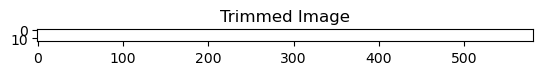

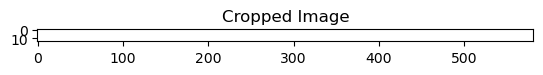

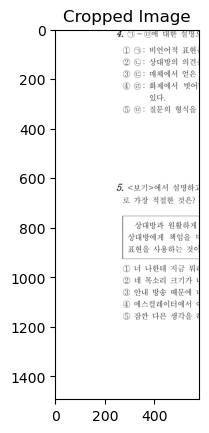

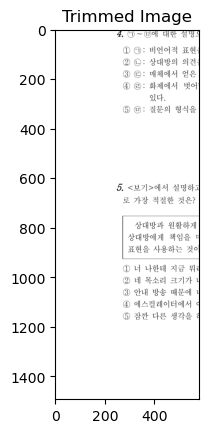

No template match found for C:\Users\BIG3-06\Downloads\MAHT_page1 (1).png
No template match found for C:\Users\BIG3-06\Downloads\MAHT_page1 (2).png
No template match found for C:\Users\BIG3-06\Downloads\MAHT_page1.png


In [31]:
import numpy as np
import cv2
import glob
import os
from matplotlib import pyplot as plt

def contour(page_rl, templates):
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)

    for template_path in templates:
        template = cv2.imread(template_path, 0)
        if template is None:
            print(f"Failed to load template: {template_path}")
            continue
        w, h = template.shape[::-1]
        res = cv2.matchTemplate(imgray, template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= 0.5)

        if len(loc[0]) > 0:
            pt = (loc[1][0], loc[0][0])  # Use the first found point
            img_trim = page_rl[pt[1]:pt[1]+h-50, :]
            if img_trim.size == 0:
                print(f"Empty image after cropping at point: {pt}")
                continue
            plt.imshow(cv2.cvtColor(img_trim, cv2.COLOR_BGR2RGB))
            plt.title('Trimmed Image')
            plt.show()
            include(img_trim, qnum)

            # Process remaining part
            img_trim = page_rl[pt[1]+h-50:, :]
            include(img_trim, qnum)
            plt.imshow(cv2.cvtColor(img_trim, cv2.COLOR_BGR2RGB))
            plt.title('Trimmed Image')
            plt.show()
            break  # Exit loop after processing one template match
        else:
            print(f"No template match found for {template_path}")

def include(cropped, num):
    global qnum
    newfile = save_path + str(num) + "_pg" + j + ".png"
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Image')
    plt.show()
    cv2.imwrite(newfile, cropped)
    qnum = qnum + 1

# 한 페이지를 반 페이지로 나누기
def imtrim(image, page_num):
    height, width, _ = image.shape
    center = width // 2
    left = image[:, :center]
    right = image[:, center:]
    return left, right

# 페이지 URL을 입력하면 크롭
def problem_crop(image_url, page_num):
    # 이미지 URL을 OpenCV에 읽어들이기
    imgfile = image_url
    image = cv2.imread(imgfile)

    # 한 페이지를 반 페이지로 나누기
    left, right = imtrim(image, page_num)

    # 각 반 페이지에 대해 크롭 진행
    contour(left, templates)
    contour(right, templates)

# 함수 실행
if __name__ == "__main__":
    qnum = 1

    load_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_crop'
    save_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_crop'
    os.chdir(load_path)

    images = glob.glob('./*.png')

    # 폴더 내 이미지 순서대로 불러오기
    images.sort()
    print(images)

    # 템플릿 이미지 경로 리스트
    templates = [
        r"C:\Users\BIG3-06\Downloads\MAHT_page1 (1).png",
        r"C:\Users\BIG3-06\Downloads\MAHT_page1 (2).png",
        r'C:\Users\BIG3-06\Downloads\MAHT_page1.png'
    ]

    for i in range(len(images)):
        filename = images[i]
        page_num = filename[20:23]
        j = page_num

        problem_crop(filename, j)


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 템플릿 이미지 경로 리스트
templates = [
    r"C:\Users\BIG3-06\Downloads\MAHT_page1 (1).png",
    r"C:\Users\BIG3-06\Downloads\MAHT_page1 (2).png",
    r'C:\Users\BIG3-06\Downloads\MAHT_page1.png'
]

# 원본 이미지 읽기
img_rgb = cv2.imread(r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\MAHT_page1.png')

# 템플릿 이미지 로드 및 매칭
for template_path in templates:
    template = cv2.imread(template_path,0)
    if template is None:
        print(f"Failed to load template: {template_path}")
        continue

    h, w = template.shape[::-1]

    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.65
    loc = np.where(res >= threshold)

    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

# OpenCV의 이미지를 matplotlib를 이용해 보여주기
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)  # OpenCV에서 RGB 순서로 변환
plt.imshow(img_rgb)
plt.title('Template Matching Result')
plt.axis('off')  # 이미지 축 제거
plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\templmatch.cpp:588: error: (-215:Assertion failed) corr.rows <= img.rows + templ.rows - 1 && corr.cols <= img.cols + templ.cols - 1 in function 'cv::crossCorr'


In [50]:
print(pt)

(235, 1976)


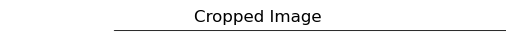

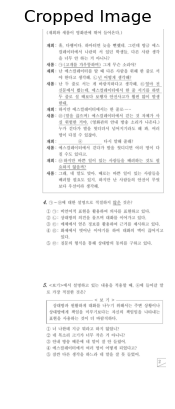

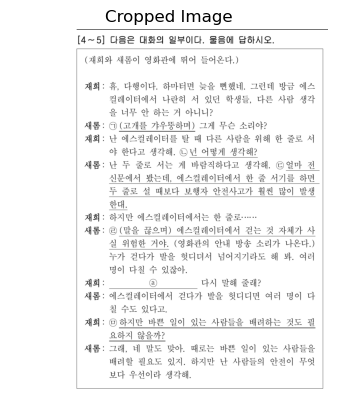

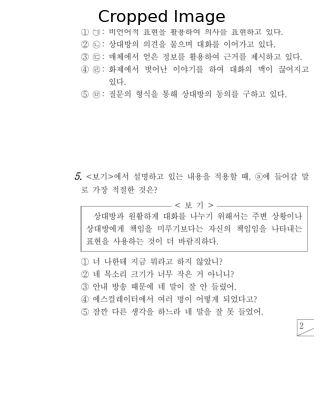

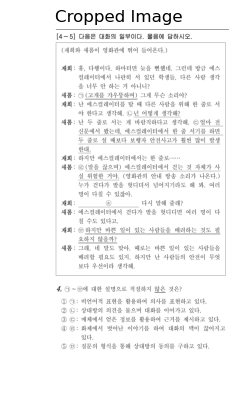

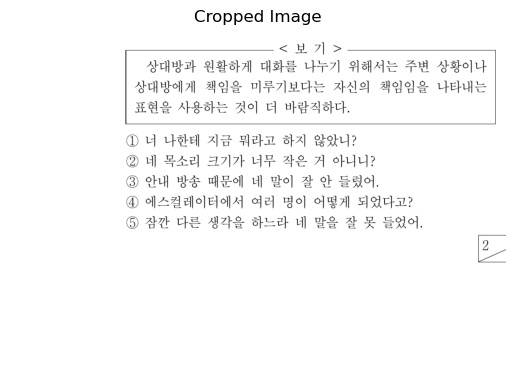

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# 함수 정의: 이미지를 잘라서 저장하는 함수
def include(cropped, qnum):
    # 저장할 파일 경로 설정
    newfile = f"result_{qnum}.png"
    # 이미지 저장
    cv2.imwrite(newfile, cropped)
    # 잘린 이미지 시각화
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Image')
    plt.axis('off')
    plt.show()

# 함수 정의: 이미지에서 특정 템플릿을 기준으로 아래 영역을 자르는 함수
def crop_below_template_match(page_rl, template_path, threshold=0.5):
    # 이미지 흑백 변환
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)
    
    # 템플릿 이미지 로드
    template = cv2.imread(template_path, 0)
    if template is None:
        print(f"Failed to load template: {template_path}")
        return
    
    # 템플릿 매칭 수행
    res = cv2.matchTemplate(imgray, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)

    # 자를 이미지의 시작 y좌표 초기화
    y_now = 0
    
    # 이전 탐지 좌표 초기화
    pt_past = 0
    
    # 탐지한 모든 "답" 이미지 영역에 대해 반복
    for pt in zip(*loc[::-1]):
        pt_now = pt[1]  # 현재 탐지한 "답" 이미지의 y 좌표

        # 같은 "답" 이미지가 여러번 탐지되는 것을 방지하기 위해 y 좌표가 이전보다 충분히 큰 경우에만 처리
        if pt_now >= pt_past + 3:
            # 이미지 잘라내기
            img_trim = page_rl[y_now:pt_now, :]
            include(img_trim, qnum)  # 잘린 이미지 저장 및 출력
            
            # 다음 이미지 자를 시작 y좌표 업데이트
            y_now = pt_now + template.shape[0] + 25
        
        # 현재 탐지 좌표를 이전 탐지 좌표로 업데이트
        pt_past = pt_now
    
    # 남은 이미지 부분을 마지막으로 처리
    img_trim = page_rl[y_now:, :]
    include(img_trim, qnum)

# 메인 코드: 원본 이미지 읽기 및 처리
if __name__ == "__main__":
    qnum = 1  # 저장할 이미지 번호 초기화
    
    # 원본 이미지 경로 설정
    img_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left_MAHT_page1.png'
    img_rgb = cv2.imread(img_path)

    # 템플릿 이미지 경로 리스트 설정
    template_dir = r'C:\Users\BIG3-06\Downloads'  # 템플릿 이미지 디렉토리
    templates = [
        os.path.join(template_dir, 'MAHT_page1 (1).png'),
        os.path.join(template_dir, 'MAHT_page1 (2).png'),
        os.path.join(template_dir, 'MAHT_page1.png')
    ]

    # 각 템플릿에 대해 아래 영역을 자르고 처리
    for template_path in templates:
        crop_below_template_match(img_rgb, template_path)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


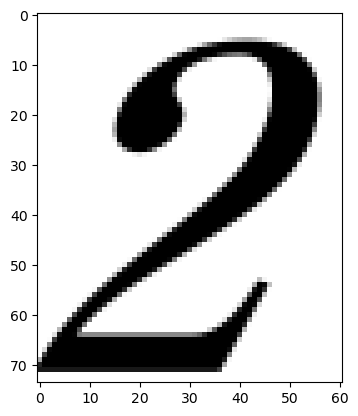

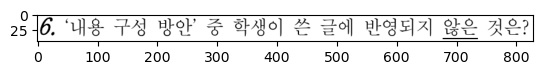

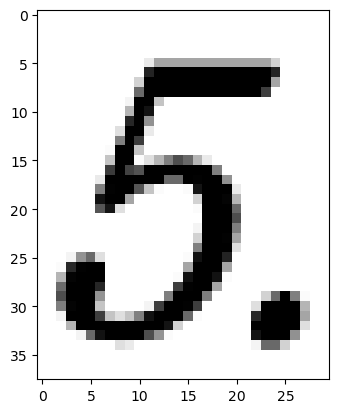

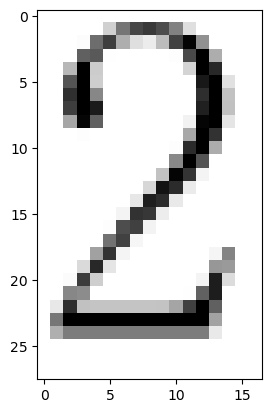

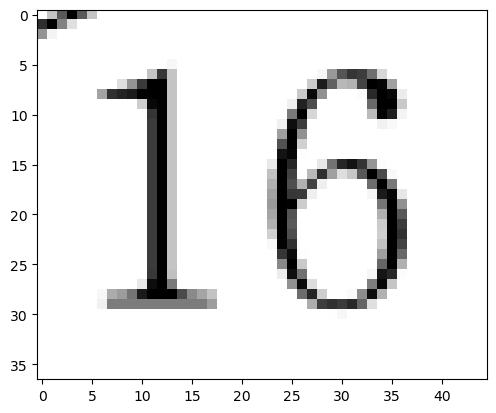

In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import easyocr

# EasyOCR 리더 생성
reader = easyocr.Reader(['ko', 'en'])

# 컨투어 검출 및 자르기 함수
def contour(page_rl):
    # 그레이스케일 변환
    imgray = cv2.cvtColor(page_rl, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러 적용 및 이진화
    blur = cv2.GaussianBlur(imgray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 엣지 검출 (캐니 엣지 검출)
    edge = cv2.Canny(blur, 100, 200)

    # 모폴로지 연산
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1000, 50))
    closed = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, kernel)

    # 컨투어 검출
    contours, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # OCR을 사용하여 숫자로 시작하는 텍스트 찾기
    result = reader.readtext(page_rl)

    # 숫자로 시작하는 텍스트의 바운딩 박스를 리스트에 추가
    number_starting_contours = []
    for (bbox, text, prob) in result:
        if prob > 0.5 and text.strip()[0].isdigit():  # 확률이 50% 이상이고 텍스트가 숫자로 시작하는 경우
            x_min, y_min = int(bbox[0][0]), int(bbox[0][1])
            x_max, y_max = int(bbox[2][0]), int(bbox[2][1])
            number_starting_contours.append((x_min, y_min, x_max - x_min, y_max - y_min))

    # 숫자로 시작하는 컨투어에 대해 처리
    for x, y, w, h in number_starting_contours:
        # 경계 사각형을 기준으로 이미지 자르기
        img_trim = page_rl[y:y+h, x:x+w]

        # 자른 이미지 보여주기
        plt.imshow(cv2.cvtColor(img_trim, cv2.COLOR_BGR2RGB))
        plt.show()

# 페이지 처리 및 문제 자르기 함수
def problem_crop(image_url):
    # OpenCV를 사용하여 이미지 읽기
    imgfile = image_url
    image = cv2.imread(imgfile)

    # 컨투어 검출 및 자르기 함수 호출
    contour(image)

# 메인 함수로 스크립트 실행
if __name__ == "__main__":
    problem_crop(r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\MAHT_page1.png')


In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 템플릿 이미지 경로 리스트
templates = [
    r"C:\Users\BIG3-06\Downloads\MAHT_page1 (1).png",
    r"C:\Users\BIG3-06\Downloads\MAHT_page1 (2).png",
    r'C:\Users\BIG3-06\Downloads\MAHT_page1.png'
]

# 원본 이미지 경로
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left_MAHT_page1.png'

# 원본 이미지 읽기
img_rgb = cv2.imread(image_path)

if img_rgb is None:
    print(f"Failed to load image: {image_path}")
    exit()

# 템플릿 이미지 로드 및 매칭
for template_path in templates:
    template = cv2.imread(template_path)

    if template is None:
        print(f"Failed to load template: {template_path}")
        continue

    # Ensure both images are in the same data type (uint8)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Perform template matching
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.65
    loc = np.where(res >= threshold)

    h, w = template.shape[:-1]

    # Draw rectangles around matched regions
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

# Show the result using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title('Template Matching Result')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


Failed to load image: C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left_MAHT_page1.png


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


: 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[242, 16], [1044, 16], [1044, 60], [242, 60]],
  '[1 ~3] 다음은 화번에 대한 강연이다. 물음에 답하시오.',
  0.39115543536460595),
 ([[293, 93], [474, 93], [474, 137], [293, 137]],
  '여러분   혹시',
  0.7587176470673871),
 ([[489, 93], [664, 93], [664, 137], [489, 137]],
  '"말   한마디에',
  0.7458703627962887),
 ([[674, 91], [1122, 91], [1122, 140], [674, 140]],
  '천 낭 빗도 갚는다 "라는  속담올',
  0.20756027626384377),
 ([[271, 136], [1122, 136], [1122, 187], [271, 187]],
  '알고 계십니까? 말울 잘하면 어려운 일도 해결활 수 있다는 뜻',
  0.306879917640405),
 ([[270, 191], [367, 191], [367, 231], [270, 231]], '이지요', 0.9998514071913761),
 ([[378, 186], [1121, 186], [1121, 231], [378, 231]],
  '그런데   정말   말만   잘하면   돌까요?   꼭 그렇지만은 않은',
  0.32881906446123543),
 ([[270, 233], [1088, 233], [1088, 278], [270, 278]],
  '것  같습니다.  먼저 이와  관련한  실험올 소개해 드리켓습니다.',
  0.3021395067210669),
 ([[292, 276], [1119, 276], [1119, 325], [292, 325]],
  '우선   초등학교  1학년   아이들   20명에게  남학생이   책상   사이',
  0.5233556766953527),
 ([[270, 325], [1121, 325], [1121, 369], [270

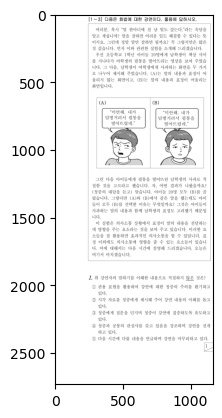

In [63]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left__page0.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

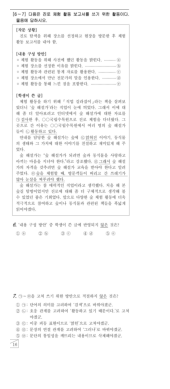

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


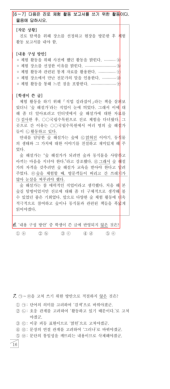

In [74]:
import cv2
import easyocr
import re
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
f_name = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_right__page1.png'

# 이미지 열기
pil_im = Image.open(f_name, 'r')
plt.imshow(pil_im)
plt.axis('off')
plt.show()

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])
results = reader.readtext(f_name)

# 찾을 패턴 설정
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'

# 숫자와 점 다음 영역을 찾기 위한 초기 변수 설정
start_x = 0
start_y = 0
end_x = 0
end_y = pil_im.size[1]  # 이미지의 높이를 최대값으로 설정 (마지막 픽셀까지 자름)
found_pattern = False

# 숫자와 점 다음 영역의 시작점 찾기
for (bbox, text, prob) in results:
    if re.match(pattern1, text) or re.match(pattern2, text):
        start_x, start_y = bbox[0]
        found_pattern = True
        break

# 시작점 이후에 나오는 패턴의 높이를 기준으로 끝점 설정
if found_pattern:
    for (bbox, text, prob) in results:
        if bbox[0][1] > start_y and (re.match(pattern1, text) or re.match(pattern2, text)):
            end_x, end_y = bbox[2]  # 네 번째 점의 좌표를 사용하여 사각형 그리기
            break

# 이미지를 numpy 배열로 변환
image_cv = cv2.imread(f_name)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# 패턴이 있는 경우, 해당 영역까지 자르기
if found_pattern:
    cropped_image = image_cv[start_y:end_y, start_x:end_x]
else:
    cropped_image = image_cv[start_y:, start_x:]  # 패턴이 없는 경우, 이미지의 끝까지 자르기

# 사각형 그리기 (있는 경우에만)
if found_pattern:
    cv2.rectangle(image_cv, (int(start_x), int(start_y)), (int(end_x), int(end_y)), (255, 0, 0), 2)

# 결과 이미지 출력
plt.imshow(image_cv)
plt.axis('off')
plt.show()


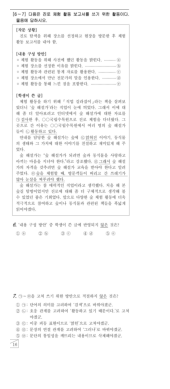

KeyboardInterrupt: 

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 파일 경로
f_name = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_right__page1.png'

# 템플릿 이미지 경로 리스트
template_paths = [
    r"C:\Users\BIG3-06\Downloads\MAHT_page1.png",
    r"C:\Users\BIG3-06\Downloads\MAHT_page1 (1).png",
    r"C:\Users\BIG3-06\Downloads\MAHT_page1 (2).png"
]

# 템플릿 매칭 함수
def match_template(image, template):
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    return max_val, max_loc

# 다음 템플릿이 나타날 때까지 영역을 찾는 함수
def find_next_template_area(image, start_loc, template):
    h, w = template.shape
    top_left = start_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    found_next_template = False
    while not found_next_template:
        cropped_area = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        
        # 다음 템플릿 매칭을 시도
        _, next_loc = match_template(cropped_area, template)
        
        if next_loc is not None:
            # 다음 템플릿이 발견되면 좌표를 전체 이미지 기준으로 변환
            next_top_left = (top_left[0] + next_loc[0], top_left[1] + next_loc[1])
            next_bottom_right = (next_top_left[0] + w, next_top_left[1] + h)
            
            # 다음 템플릿의 위치가 기존 영역 안에 있는지 확인
            if next_top_left[1] >= 0 and next_bottom_right[1] <= image.shape[0]:
                # 기존 영역 안에 있는 경우, 다음 템플릿의 위치로 업데이트
                top_left = next_top_left
                bottom_right = next_bottom_right
            else:
                # 기존 영역 밖으로 나가는 경우, 종료
                found_next_template = True
        else:
            # 다음 템플릿이 더 이상 없는 경우, 종료
            found_next_template = True
    
    return top_left, bottom_right

# 이미지 열기
pil_im = Image.open(f_name, 'r')
plt.imshow(pil_im)
plt.axis('off')
plt.show()

# 이미지를 numpy 배열로 변환 및 그레이스케일 변환
image_cv = cv2.imread(f_name, cv2.IMREAD_GRAYSCALE)

# 첫 번째 템플릿 매칭을 사용하여 가장 일치하는 영역 찾기
best_template = None
best_val = -1
best_loc = None

for template_path in template_paths:
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    val, loc = match_template(image_cv, template)
    
    if val > best_val:
        best_val = val
        best_template = template
        best_loc = loc

if best_loc is not None:
    # 템플릿과 일치하는 영역의 좌표 계산
    h, w = best_template.shape
    top_left = best_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    # 다음 템플릿이 나타날 때까지 영역을 찾기
    final_top_left, final_bottom_right = find_next_template_area(image_cv, top_left, best_template)
    
    # 템플릿과 일치하는 영역 크롭
    cropped_area = image_cv[final_top_left[1]:final_bottom_right[1], final_top_left[0]:final_bottom_right[0]]

    
    
    # 결과 이미지 출력
    plt.imshow(cropped_area, cmap='gray')  # 그레이스케일로 출력
    plt.axis('off')
    plt.show()
else:
    print("No matching template found.")
